In [1]:
!pip install transformers

In [2]:
!pip install sentencepiece

In [3]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from transformers import TFAutoModel,AutoTokenizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
train = pd.read_csv('/kaggle/input/d/tiensynguyen41/nli-dataset/train_1.csv', encoding='utf-16')
val = pd.read_csv('/kaggle/input/d/tiensynguyen41/nli-dataset/val_1.csv', encoding='utf-16')
test = pd.read_csv('/kaggle/input/d/tiensynguyen41/nli-dataset/test_1.csv', encoding='utf-16')

In [6]:
# Map labels to numerical values
label_mapping = {"agree": 0, "disagree": 2, "neutral": 1}
train.label = train["label"].map(label_mapping)
val.label = val["label"].map(label_mapping)
test.label = test["label"].map(label_mapping)

In [7]:
# Convert sentences to lowercase
for df in [train, val, test]:
    df["sentence_1"] = df["sentence_1"].str.lower()
    df["sentence_2"] = df["sentence_2"].str.lower()

In [ ]:
# Define replacements
replacements = {
    'coronavirus': 'virus corona', 'COVID-19': 'virus corona', 'SARS-COV-2': 'virus corona',
    'covid-19': 'virus corona', 'covid': 'virus corona', 'Covid': 'virus corona',
    'sars-cov-2': 'virus corona', 'Sars-cov-2': 'virus corona', 'viruses': 'virus',
    'Viruses': 'virus', 'vi rút': 'virus', 'Vi rút': 'virus', 'vi-rút': 'virus',
    'Vi-rút': 'virus', 'vắc-xin': 'vaccine', 'Vắc-xin': 'vaccine', 'vắc xin': 'vaccine',
    'Vắc xin': 'vaccine', 'cô-rô-na': 'virus corona', 'Cô-rô-na': 'virus corona'
}

In [8]:
# Apply replacements
for df in [train, val, test]:
    df["sentence_1"] = df["sentence_1"].replace(replacements, regex=True)
    df["sentence_2"] = df["sentence_2"].replace(replacements, regex=True)

In [9]:
token = '<your_token>'
tokenizer = AutoTokenizer.from_pretrained('microsoft/infoxlm-large', token=token)

config.json:   0%|          | 0.00/513 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [11]:
# Load pre-trained model
xlm_roberta = TFAutoModel.from_pretrained("microsoft/infoxlm-large", from_pt=True)
xlm_roberta_output = xlm_roberta([input_ids, input_mask])[0]

# Add layers to the model
output = tf.keras.layers.GlobalAveragePooling1D()(xlm_roberta_output)
output = tf.keras.layers.Dense(units=64, activation=tf.nn.relu)(output)
output = tf.keras.layers.Dense(units=32, activation=tf.nn.relu)(output)
output = tf.keras.layers.Dense(3, activation='softmax')(output)

# Compile model
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

pytorch_model.bin:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFXLMRobertaModel.

All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 100)]                0         []                            
                                                                                                  
 tfxlm_roberta_model (TFXLM  TFBaseModelOutputWithPooli   5598904   ['input_word_ids[0][0]',      
 RobertaModel)               ngAndCrossAttentions(last_   32         'input_mask[0][0]']          
                             hidden_state=(None, 100, 1                                       

In [16]:
def prepare_data(df, tokenizer):
    sentences = df[['sentence_1', 'sentence_2']].values.tolist()
    encodings = tokenizer.batch_encode_plus(sentences, padding='max_length', max_length=100, truncation=True, return_attention_mask=True)
    input_ids = tf.convert_to_tensor(encodings['input_ids'], dtype=tf.int32)
    input_mask = tf.convert_to_tensor(encodings['attention_mask'], dtype=tf.int32)
    return {'input_word_ids': input_ids, 'input_mask': input_mask}

In [17]:
train_input = prepare_data(train, tokenizer)
val_input = prepare_data(val, tokenizer)

In [18]:
history = model.fit(train_input, np.asarray(train.label).astype(np.int32), epochs=10,
              validation_data=(val_input, np.asarray(val.label).astype(np.int32)),
              batch_size=8, verbose=1)

Epoch 1/10
1618/1618 [==============================] - 719s 388ms/step - loss: 0.5893 - accuracy: 0.7457 - val_loss: 0.3272 - val_accuracy: 0.8857
Epoch 2/10
1618/1618 [==============================] - 609s 377ms/step - loss: 0.2775 - accuracy: 0.9039 - val_loss: 0.2341 - val_accuracy: 0.9209
Epoch 3/10
1618/1618 [==============================] - 609s 377ms/step - loss: 0.1903 - accuracy: 0.9352 - val_loss: 0.2081 - val_accuracy: 0.9314
Epoch 4/10
1618/1618 [==============================] - 608s 376ms/step - loss: 0.1370 - accuracy: 0.9543 - val_loss: 0.1971 - val_accuracy: 0.9419
Epoch 5/10
1618/1618 [==============================] - 609s 376ms/step - loss: 0.0977 - accuracy: 0.9684 - val_loss: 0.2046 - val_accuracy: 0.9518
Epoch 6/10
1618/1618 [==============================] - 610s 377ms/step - loss: 0.0974 - accuracy: 0.9696 - val_loss: 0.2027 - val_accuracy: 0.9450
Epoch 7/10
1618/1618 [==============================] - 609s 377ms/step - loss: 0.0602 - accuracy: 0.9811 - val_

In [ ]:
model.save('infoXLM-RoBERTa_L.h5')

In [20]:
test_input = prepare_data(test, tokenizer)

51/51 [==============================] - 26s 388ms/step
Evaluation result:

              precision    recall  f1-score   support

       agree     0.9587    0.9513    0.9550       513
    disagree     0.9611    0.9594    0.9602       566
     neutral     0.9596    0.9685    0.9640       539

    accuracy                         0.9598      1618
   macro avg     0.9598    0.9597    0.9597      1618
weighted avg     0.9598    0.9598    0.9598      1618



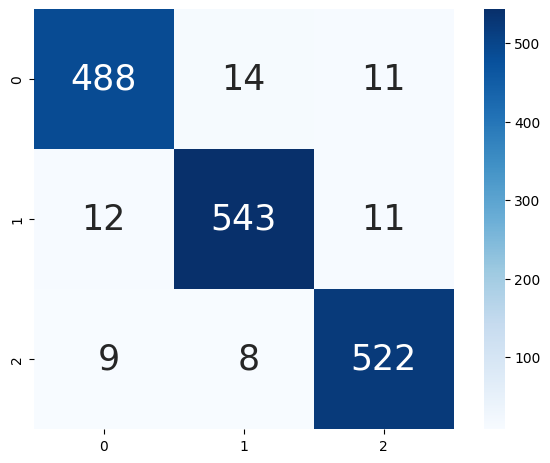

In [21]:
# Predict on test data
y = model.predict(test_input)
predict = [np.argmax(y[i]) for i in range(len(y))]

# Map numerical predictions back to labels
test["label_predict"] = predict
test["label"] = test["label"].map({0: 'agree', 1: 'neutral', 2: 'disagree'})
test["label_predict"] = test["label_predict"].map({0: 'agree', 1: 'neutral', 2: 'disagree'})

# Confusion matrix and classification report
label = test["label"].to_list()
label_pre = test["label_predict"].to_list()

cm_cst_nb = confusion_matrix(label, label_pre)
plt.figure(figsize=(17, 12))

plt.subplot(2, 2, 1)
df_cm_cst_nb = pd.DataFrame(cm_cst_nb, index=['agree', 'neutral', 'disagree'], columns=['agree', 'neutral', 'disagree'])
sns.heatmap(df_cm_cst_nb, annot=True, square=True, annot_kws={"size": 25}, fmt='2g', cmap='Blues')

print('Evaluation result:\n')
print(classification_report(label, label_pre, digits=4))